In [1]:
import pandas as pd

# Load a sample of the big dataset (modify the number as per your machine's memory)
train_data = pd.read_csv('train.csv', names=['polarity', 'title', 'text'], nrows=200000)
test_data = pd.read_csv('test.csv', names=['polarity', 'title', 'text'], nrows=50000)

# Map labels: class 1 → 0 (negative), class 2 → 1 (positive)
train_data['polarity'] = train_data['polarity'].map({1: 0, 2: 1})
test_data['polarity'] = test_data['polarity'].map({1: 0, 2: 1})

# Combine title and text as review input
train_data['review'] = train_data['title'].astype(str) + " " + train_data['text'].astype(str)
test_data['review'] = test_data['title'].astype(str) + " " + test_data['text'].astype(str)

# Final data
sentiment = pd.concat([train_data[['review', 'polarity']], test_data[['review', 'polarity']]], ignore_index=True)
sentiment.rename(columns={'review': 'text', 'polarity': 'labels'}, inplace=True)

# Drop missing and duplicated
sentiment.dropna(inplace=True)
sentiment.drop_duplicates(inplace=True)


In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Input, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define text cleaning function
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text
    text = re.sub(r'\W', ' ', str(text)) # Remove all special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetical characters
    text = text.lower() # Convert to lowercase
    words = word_tokenize(text) # Tokenize text
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words] # Lemmatization
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words and len(word) > 3] # Remove stopwords and short words
    return words


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Reuse your process_text function
cleaned_text = [process_text(text) for text in sentiment['text']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, sentiment['labels'], test_size=0.2, random_state=42)


In [4]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)


In [5]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=2)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=2)


In [6]:
import pickle

# Save tokenizer
with open("amazon_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save label encoder
with open("amazon_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


In [7]:
from keras.models import Model
from keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional
from keras.optimizers import Adam

input_layer = Input(shape=(100,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_layer)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(200))(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # 2 classes: negative and positive

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
import os
from tensorflow.keras.models import load_model

# Check if model file exists
if os.path.exists("gru_sentiment_amazon.h5"):
    model = load_model("gru_sentiment_amazon.h5")
    print("Model loaded from file.")
else:
    # Train the model if not already saved
    history = model.fit(
        X_train_seq,
        y_train_one_hot,
        epochs=40,
        batch_size=64,
        validation_data=(X_test_seq, y_test_one_hot),
        callbacks=[early_stop]
    )
    model.save("gru_sentiment_amazon.h5")
    print("Model trained and saved.")


Model loaded from file.


In [11]:
# Save the trained model after training completes
model.save("gru_sentiment_amazon.h5")
print("Model saved as 'gru_sentiment_amazon.h5'")


Model saved as 'gru_sentiment_amazon.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
Review: 'This product is amazing!' → Predicted Sentiment: 1
Review: 'Terrible customer service.' → Predicted Sentiment: 0


In [15]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_one_hot, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.8929 - loss: 0.2872
Test Accuracy: 0.8906
Test Loss: 0.2906


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_encoded  # already label-encoded

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Negative', 'Positive']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89     24698
    Positive       0.89      0.90      0.89     25302

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000

Confusion Matrix:
[[21746  2952]
 [ 2516 22786]]


In [9]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Input, GlobalMaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

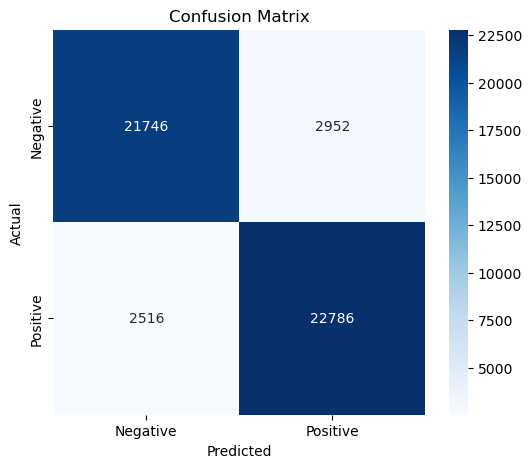

In [ ]:
import seaborn as sns

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


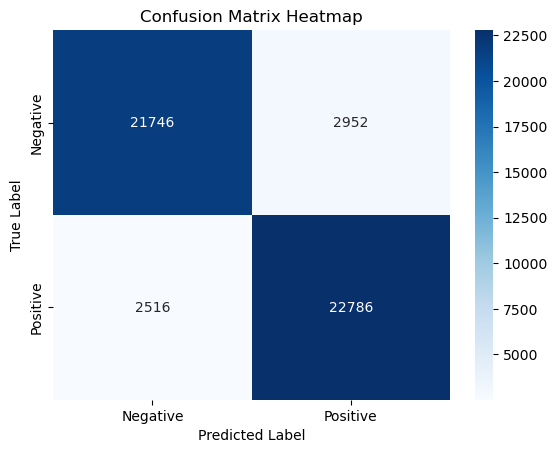

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [13]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as dictionary
report = classification_report(y_true_classes, y_pred_classes, target_names=['Negative', 'Positive'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the DataFrame
print("Classification Report:")
print(report_df.round(2))


Classification Report:
              precision  recall  f1-score   support
Negative           0.90    0.88      0.89  24698.00
Positive           0.89    0.90      0.89  25302.00
accuracy           0.89    0.89      0.89      0.89
macro avg          0.89    0.89      0.89  50000.00
weighted avg       0.89    0.89      0.89  50000.00


In [14]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install graphviz 

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------------------------- ------------- 30.7/47.1 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 784.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install visualkeras


   ---------------------------------------- 0.0/45.1 kB ? eta -:--:--
   ---------------------------------------- 45.1/45.1 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import visualkeras
visualkeras.layered_view(model, legend=True).show()



c:\Users\91798\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [23]:
from tensorflow.keras.models import load_model

model = load_model("gru_sentiment_amazon.h5")  # Load your trained model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │    14,196,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400)            │       362,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,571,600 (55.59 MB)

 Trainable params: 14,571,598 (55.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

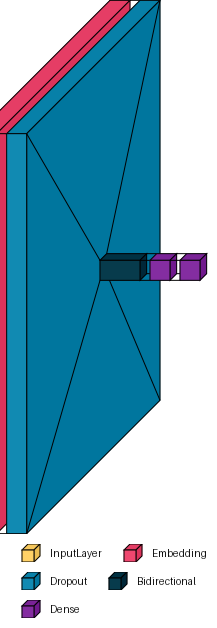

In [24]:
import visualkeras
from tensorflow.keras.models import load_model

# Generate and show the model architecture
visualkeras.layered_view(model, legend=True)


In [26]:
pip install pydot-ng pillow

Note: you may need to restart the kernel to use updated packages.


In [27]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

model = load_model("gru_sentiment_amazon.h5")
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


AttributeError: module 'pydot' has no attribute 'InvocationException'